# VASP TiO2 benchmark performance

This notebook compares the performance of the TiO2 benchmark across different HPC facilities.

We compute the mean time per SCF cycle from all cycles in the output file apart from the fastest and slowest cycle times. Performance is plotted as SCF cycles per second.

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [5]:
results = ['ARCHER','ARCHER2','ARCHER2-MKL193']
systems = {'ARCHER': 'ARCHER', 'ARCHER2': 'ARCHER2', 'ARCHER2-MKL193': 'ARCHER2'}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../TiO2/results/' + res
    filelist = filemanip.get_filelist(wdir, 'TiO2MCC_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
2     48        1       4    1     0.000738  0.000738  0.000738  0.000738   
                        8    1     0.000716  0.000716  0.000716  0.000716   
4     96        1       4    1     0.001441  0.001441  0.001441  0.001441   
                        8    1     0.001454  0.001454  0.001454  0.001454   
8     192       1       4    1     0.002767  0.002767  0.002767  0.002767   
16    384       1       4    1     0.004865  0.004865  0.004865  0.004865   
32    768       1       4    1     0.011049  0.011049  0.011049  0.011049   

                                         SCF                                   \
                                         min     median        max       mean   
Nodes Processes Threads NPAR KPAR                          

                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
1     128       1       4    1     0.001413  0.001413  0.001413  0.001413   
2     256       1       2    1     0.003697  0.003697  0.003697  0.003697   
4     512       1       4    1     0.007136  0.007136  0.007136  0.007136   
                        128  1     0.004720  0.004720  0.004720  0.004720   
8     1024      1       8    1     0.013768  0.013768  0.013768  0.013768   
                        128  1     0.009908  0.009908  0.009908  0.009908   
16    2048      1       16   1     0.009741  0.009741  0.009741  0.009741   
                        128  1     0.010021  0.010021  0.010021  0.010021   
32    4096      1       64   1     0.005303  0.005303  0.005303  0.005303   

                                        SCF                                

## Performance Comparison

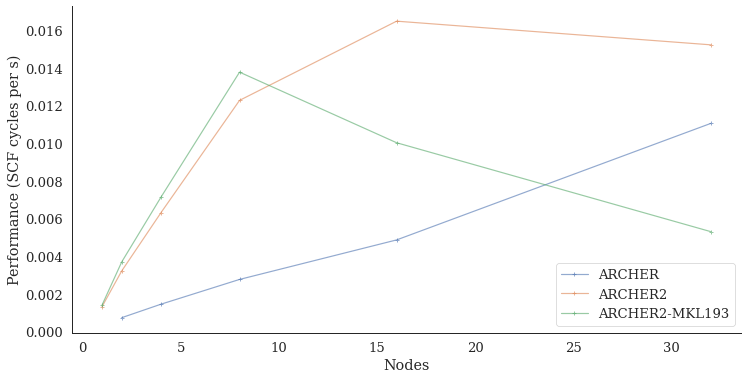

In [6]:
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

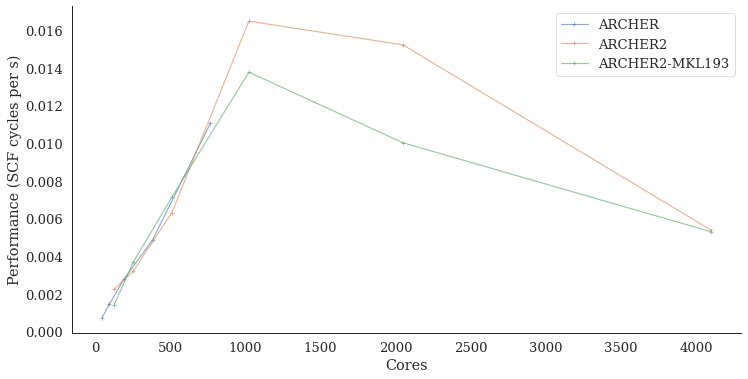

In [7]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

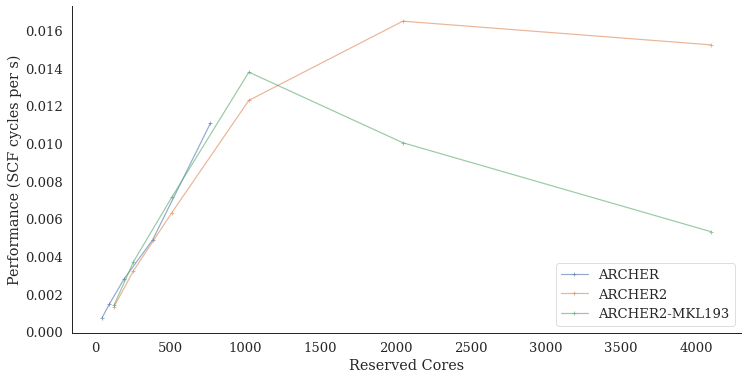

In [8]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

## ARCHER2 Cray LibSci vs. MKL performance

A comparison of the performance of the same version of VASP using different numerical libraries

In [9]:
print(f"{'Nodes':>5s} {'LibSci':>10s} {'MKL':>10s} {'Ratio':>10s}")
for i in range(min(len(nodes['ARCHER2']),len(nodes['ARCHER2-MKL193']))):
    n = nodes['ARCHER2'][i]
    perfLS = perf_nodes['ARCHER2'][i]
    perfMKL = perf_nodes['ARCHER2-MKL193'][i]
    ratio = perfLS/perfMKL
    print(f"{n:>5d} {perfLS:>10.5f} {perfMKL:>10.5f} {ratio:>10.5f}")

Nodes     LibSci        MKL      Ratio
    1    0.00133    0.00141    0.93991
    2    0.00322    0.00370    0.87061
    4    0.00631    0.00714    0.88454
    8    0.01227    0.01377    0.89118
   16    0.01647    0.01002    1.64392
   32    0.01522    0.00530    2.86975
